# A/B Test: A New Menu Launch
## Project Overview
You're a business analyst for Round Roasters, a coffee restaurant in the United States of America. The executive team conducted a market test with a new menu and needs to figure whether the new menu can drive enough sales to offset the cost of marketing the new menu. Your job is to analyze the A/B test and write up a recommendation to whether the Round Roasters chain should launch this new menu.

In [57]:
# Load package
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from sklearn.neighbors import KDTree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [12, 12]

## Step 1: Plan Your Analysis
To perform the correct analysis, you will need to prepare a data set. Prior to rolling up your sleeves and preparing the data, it’s a good idea to have a plan of what you need to do in order to prepare the correct data set. A good plan will help you with your analysis. Here are a few questions to get you started:

-What is the performance metric you’ll use to evaluate the results of your test?  
-What is the test period?  
-At what level (day, week, month, etc.) should the data be aggregated?  

In [58]:
# load Stores data
stores_data = pd.read_csv('round-roaster-stores.csv')
stores_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   StoreID                  133 non-null    int64  
 1   Sq_Ft                    133 non-null    int64  
 2   AvgMonthSales            133 non-null    int64  
 3   Right_Name               133 non-null    object 
 4   Phone Number             130 non-null    object 
 5   Street Combined          133 non-null    object 
 6   Street 1                 133 non-null    object 
 7   Street 2                 37 non-null     object 
 8   Street 3                 25 non-null     object 
 9   City                     133 non-null    object 
 10  State                    133 non-null    object 
 11  Postal Code              133 non-null    int64  
 12  Region                   133 non-null    object 
 13  Country                  133 non-null    object 
 14  Coordinates              1

In [59]:
stores_data.head(3)

,StoreID,Sq_Ft,AvgMonthSales,Right_Name,Phone Number,Street Combined,Street 1,Street 2,Street 3,City,State,Postal Code,Region,Country,Coordinates,Latitude,Longitude,Timezone,Current Timezone Offset,Olson Timezone
0,10018,1183,18000,Bellflower & Spring,562-420-1317,"2890 N Bellflower Blvd, #A-1, The Los Altos Ma...",2890 N Bellflower Blvd,#A-1,The Los Altos Marketplace,Long Beach,CA,908151125,West,US,"(33.8085823059082, -118.124931335449)",33.808582,-118.124931,Pacific Standard Time,-480,GMT-08:00 America/Los_Angeles
1,10068,1198,16000,"Foothill & Boston, La Crescenta",818-541-7693,"3747 Foothill Boulevard, A",3747 Foothill Boulevard,A,NaN,La Cresenta,CA,912141700,West,US,"(34.2375450134277, -118.26114654541)",34.237545,-118.261146,Pacific Standard Time,-480,GMT-08:00 America/Los_Angeles
2,10118,1204,13000,Magic Mountain & Tourney,661-260-0844,"25349 Wayne Mills Place, Tourney Retail Plaza",25349 Wayne Mills Place,NaN,Tourney Retail Plaza,Valencia,CA,913551827,West,US,"(34.4237022399902, -118.579261779785)",34.423702,-118.579262,Pacific Standard Time,-480,GMT-08:00 America/Los_Angeles


In [60]:
# load Transactions data
# force Invoice Date column to datetime 
transactions_data = pd.read_csv('RoundRoastersTransactions.csv', parse_dates=['Invoice Date'])
transactions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332333 entries, 0 to 4332332
Data columns (total 10 columns):
 #   Column          Dtype         
---  ------          -----         
 0   StoreID         int64         
 1   Invoice Number  int64         
 2   Invoice Date    datetime64[ns]
 3   SKU             int64         
 4   Category        object        
 5   Product         object        
 6   QTY             int64         
 7   Size            object        
 8   Gross Margin    float64       
 9   Sales           float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 330.5+ MB


In [61]:
transactions_data.head()

,StoreID,Invoice Number,Invoice Date,SKU,Category,Product,QTY,Size,Gross Margin,Sales
0,10018,16296643,2015-01-21,1043,Espresso,Mocha,3,L,6.7365,14.97
1,10018,16296643,2015-01-21,2001,Pastry,Croissant,1,NaN,1.1000,2.75
2,10018,16297717,2015-01-21,1021,Espresso,Espresso,3,S,4.1850,8.37
3,10018,16297717,2015-01-21,1022,Espresso,Espresso,4,M,5.9800,11.96
4,10018,16297717,2015-01-21,1023,Espresso,Espresso,3,L,4.7850,9.57


In [62]:
# load Treatment Stores data
treatment_stores_data = pd.read_csv('treatment-stores.csv')
treatment_stores_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   StoreID                  10 non-null     int64  
 1   Sq_Ft                    10 non-null     int64  
 2   AvgMonthSales            10 non-null     int64  
 3   Phone Number             9 non-null      object 
 4   Street Combined          10 non-null     object 
 5   Street 1                 10 non-null     object 
 6   Street 2                 1 non-null      float64
 7   Street 3                 1 non-null      object 
 8   City                     10 non-null     object 
 9   Postal Code              10 non-null     int64  
 10  Region                   10 non-null     object 
 11  Country                  10 non-null     object 
 12  Coordinates              10 non-null     object 
 13  Latitude                 10 non-null     float64
 14  Longitude                10 n

In [63]:
treatment_stores_data.head(3)

,StoreID,Sq_Ft,AvgMonthSales,Phone Number,Street Combined,Street 1,Street 2,Street 3,City,Postal Code,Region,Country,Coordinates,Latitude,Longitude,Timezone,Current Timezone Offset,Olson Timezone,Name,Right_State
0,1664,1475,11000,8478428048,"101 W. Main St., Barrington Village Center",101 W. Main St.,NaN,Barrington Village Center,Barrington,60010,Central,US,"(42.1540565490723, -88.1362915039063)",42.154057,-88.136291,Central Standard Time,-360,GMT-06:00 America/Chicago,Barrington,IL
1,1675,1472,15000,8472531188,90 East Northwest Highway,90 East Northwest Highway,NaN,NaN,Mount Prospect,60056,Central,US,"(42.0633544921875, -87.9355773925781)",42.063354,-87.935577,Central Standard Time,-360,GMT-06:00 America/Chicago,Northwest Hwy & Elmhurst Rd,IL
2,1696,1471,10000,2242232528,1261 East Higgins Road,1261 East Higgins Road,NaN,NaN,Schaumburg,60173,Central,US,"(42.039363861084, -88.048828125)",42.039364,-88.048828,Central Standard Time,-360,GMT-06:00 America/Chicago,Higgins & Meacham,IL


## Step 2: Clean Up Your Data
In this step, you should prepare the data for steps 3 and 4. You should aggregate the transaction data to the appropriate level and filter on the appropriate data ranges. You can assume that there is no missing, incomplete, duplicate, or dirty data. You’re ready to move on to the next step when you have weekly transaction data for all stores.

In [80]:
# Test cities: Denver and Chicago
# Treatment: 12 Weeks [2016-April-29 to 2016-July-21], start on Friday
# Control: 12 Weeks [(2015-April-29 to 2015-July-21], start on Wednesday
# Total weeks to identify trend and season: 52 Weeks + treatment weeks + control weeks = 52 + 12 + 12 = 76 Weeks

data_end_date = datetime(2016, 7, 21)
data_start_date = data_end_date - timedelta(weeks=76)
print(f'Data Start Date: {data_start_date} \nData End Date: {data_end_date}')

Data Start Date: 2015-02-05 00:00:00 
Data End Date: 2016-07-21 00:00:00


In [81]:
# Filter data for further process
filtered_transactions_data = transactions_data.query('`Invoice Date` > @data_start_date and `Invoice Date` <= @data_end_date')
# Make Invoice Date Index
filtered_transactions_data.set_index('Invoice Date', inplace=True)

filtered_transactions_data.head(10)

,StoreID,Invoice Number,SKU,Category,Product,QTY,Size,Gross Margin,Sales
Invoice Date,,,,,,,,,
2015-02-06,10018,16551067,1013,Espresso,Cappuccino,2,L,4.7880,7.98
2015-02-06,10018,16551067,1022,Espresso,Espresso,1,M,1.4950,2.99
2015-02-06,10018,16551067,1023,Espresso,Espresso,3,L,4.7850,9.57
2015-02-06,10018,16551067,1041,Espresso,Mocha,1,S,1.7955,3.99
2015-02-06,10018,16551067,1042,Espresso,Mocha,3,M,6.0615,13.47
2015-02-06,10018,16551067,1043,Espresso,Mocha,2,L,4.4910,9.98
2015-02-06,10018,16551067,1053,Milk,Hot Chocolate,3,L,1.5750,4.50
2015-02-06,10018,16551067,2001,Pastry,Croissant,2,NaN,2.2000,5.50
2015-02-06,10018,16555940,1021,Espresso,Espresso,2,S,2.7900,5.58


In [97]:
# Aggregate the data to get the weekly gross margin and weekly traffic count unique invoices

weekly_gross_and_traffic = filtered_transactions_data.groupby([pd.Grouper(freq='W-FRI', closed='left'), 'StoreID'], as_index=True).agg({'Gross Margin': 'sum', 'Invoice Number': 'nunique'}).reset_index()

weekly_gross_and_traffic.head()

,Invoice Date,StoreID,Gross Margin,Invoice Number
0,2015-02-13,1508,1429.4390,183
1,2015-02-13,1542,1516.7510,195
2,2015-02-13,1580,1587.9565,207
3,2015-02-13,1630,2500.4115,334
4,2015-02-13,1662,1308.3625,180


In [114]:
# Hack to start week on first date
weekly_gross_and_traffic['Invoice Date'] = weekly_gross_and_traffic['Invoice Date'] - pd.offsets.Week(1)
weekly_gross_and_traffic.head()

,Invoice Date,StoreID,Gross Margin,Invoice Number
0,2015-02-06,1508,1429.4390,183
1,2015-02-06,1542,1516.7510,195
2,2015-02-06,1580,1587.9565,207
3,2015-02-06,1630,2500.4115,334
4,2015-02-06,1662,1308.3625,180


In [115]:
# How many transactions did you get for Store 10018 in the week starting 2015-02-06?
weekly_gross_and_traffic.query('StoreID == 10018')

,Invoice Date,StoreID,Gross Margin,Invoice Number
93,2015-02-06,10018,2212.7105,308
226,2015-02-13,10018,2164.0070,288
359,2015-02-20,10018,1560.9290,204
492,2015-02-27,10018,2342.9840,320
625,2015-03-06,10018,2199.4065,284
...,...,...,...,...
9536,2016-06-17,10018,2076.4000,296
9669,2016-06-24,10018,2120.7725,318
9802,2016-07-01,10018,1584.7100,228
9935,2016-07-08,10018,1886.1660,269


In [84]:
# sum weekly margin and traffic
x = weekly_gross_and_traffic.groupby(['Invoice Date'], as_index=False).sum().drop(columns=['StoreID', 'Gross Margin'])
x.rename(columns={'Invoice Number': 'Weekly Foot Traffic'}, inplace=True)
x.head()

,Invoice Date,Weekly Foot Traffic
0,2015-02-06,3987
1,2015-02-13,31498
2,2015-02-20,34569
3,2015-02-27,30503
4,2015-03-06,31304


<AxesSubplot:xlabel='Invoice Date'>

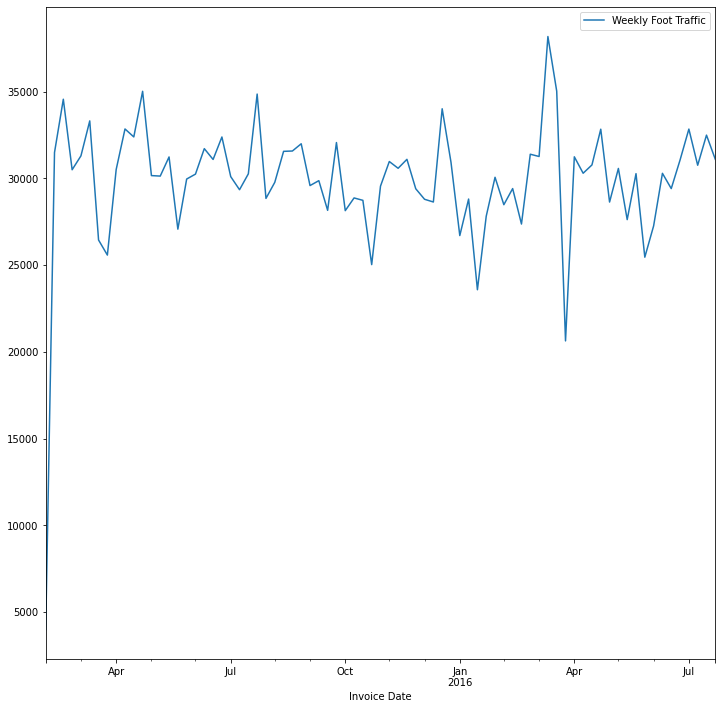

In [85]:
x.plot(x='Invoice Date', y='Weekly Foot Traffic')

## Step 3: Match Treatment and Control Units
In this step, you should create the trend and seasonality variables, and use them along with you other control variable(s) to match two control units to each treatment unit. Treatment stores should be matched to control stores in the same region. Note: Calculate the number of transactions per store per week and use 12 periods to calculate trend and seasonality.  

Apart from trend and seasonality...  

-What control variables should be considered? Note: Only consider variables in the RoundRoastersStore file.  
-What is the correlation between your each potential control variable and your performance metric? (Example of correlation matrix below)  
-What control variables will you use to match treatment and control stores?

## Step 4: Analysis and Writeup
Conduct your A/B analysis and create a short report outlining your results and recommendations.  

In an AB Analysis we use the correlation matrix to find the most correlated variable to the performance metric to include in the AB controls tool to help find the best matches.